In [1]:
import pandas as pd
import gensim.downloader as api

import seaborn as sns
from sklearn.utils import shuffle

from corpusholder import Lang, CorpusHolder
from model import Model, Learner

In [2]:
gensim_model = api.load("glove-wiki-gigaword-100")
print('gensim_model loaded')

gensim_model loaded


data=(249354, 11)
Lang=30002
CorpusHolder train_dataset=199472 val_dataset=24934 test_dataset=24935


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Liked', ylabel='count'>

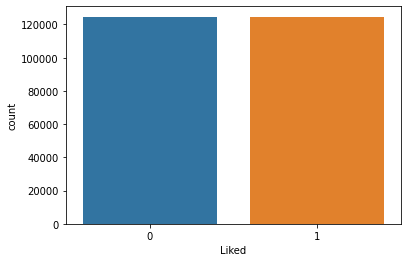

In [3]:
# AMAZON FOODS import
data = pd.read_csv('./amazon_foods/Reviews.csv')
data['Liked'] = data['Score'].apply(lambda x : 1 if x >= 4 else 0)

negatives = data[data.Liked == 0]
positives = data[data.Liked == 1].sample(n=len(negatives), random_state=1000007)
data = shuffle(positives.append(negatives).reset_index(drop=True))
print('data=%s' % str(data.shape))
corpus_holder = CorpusHolder(data['Text'].values, data['Liked'].values)
sns.countplot(data['Liked'])

In [4]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Liked
153105,125873,B005MGDP90,A26SYXM0IZMYPN,David,1,8,2,1347062400,missing salt,i went a picked up my order today and the box ...,0
25478,395290,B000H7ELTW,AYDS27E60FH0A,Glenn Leary,0,0,5,1247184000,Superb Cranberries,"<a href=""http://www.amazon.com/gp/product/B000...",1
210422,387654,B000633Y4A,AC7AY7GU4GKID,Mom of the Year,9,9,2,1340755200,Contains chicken!,Why does this bone have to contain chicken mea...,0
91394,456393,B005F0JM7W,A2EX2DK4BO680S,N. Williams,2,2,5,1337990400,Great storage for k cups,This was easy to install. After reading other ...,1
58244,442757,B001ELL2HO,AXJD9GZIJP2BH,Savvy Shopper,3,3,5,1299024000,Perfect for Snacking!,This is my second order of this wonderful ging...,1


### hyperparamers search

Let us try Optuna
<br>
https://optuna.org/

In [5]:
from optuna import create_study

BEST_ACC = 0.6

def objective(trial):
    global BEST_ACC

    model_config = {'embedding_freeze': True, 
                    'gru_hidden_size': trial.suggest_int("hidden_size", 10, 526), 
                    'gru_num_layers': trial.suggest_int("num_layers", 1, 3),
                    'gru_dropout':trial.suggest_loguniform("cell_dropout", 1e-9, 0.9), 
                    'gru_bidirectional': trial.suggest_categorical("bidirectional", [True, False]), 
                    'fc_size': trial.suggest_int("hidden_layer_size", 10, 526), 
                    'n_classes': 2}

    trymodel = Model(corpus_holder.lang, gensim_model, model_config)
    
    learner_config = {'learning_rate': trial.suggest_loguniform("lr", 1e-5, 1e-3), 
                      'n_epoch': 12, 
                      'weight_decay':trial.suggest_loguniform("weight_decay", 1e-9, 1e-1), 
                      'verbose': False}
    
    learner = Learner(trymodel, learner_config)
    val_acc, test_acc = learner.train(corpus_holder)

    if test_acc > BEST_ACC:
        BEST_ACC = test_acc
        print('val_acc=%.4f test_acc=%.4f saving optuna.ckpt' % (val_acc, test_acc))
        learner.save("optuna.ckpt")
    return val_acc

study = create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2020-12-05 21:32:10,253] A new study created in memory with name: no-name-1e2a70ac-ca75-41e6-97f9-8fe3942908cd
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


val_acc=0.8134 test_acc=0.8174 saving optuna.ckpt


[I 2020-12-05 21:59:41,816] Trial 0 finished with value: 0.8134274484639448 and parameters: {'hidden_size': 282, 'num_layers': 3, 'cell_dropout': 2.718868794297591e-07, 'bidirectional': False, 'hidden_layer_size': 321, 'lr': 1.640907641328538e-05, 'weight_decay': 0.00036535885202272097}. Best is trial 0 with value: 0.8134274484639448.
[I 2020-12-05 22:34:15,069] Trial 1 finished with value: 0.7496189941445416 and parameters: {'hidden_size': 363, 'num_layers': 3, 'cell_dropout': 2.3319413973687234e-05, 'bidirectional': False, 'hidden_layer_size': 235, 'lr': 1.0644711433703698e-05, 'weight_decay': 0.01415630739347542}. Best is trial 0 with value: 0.8134274484639448.


val_acc=0.8359 test_acc=0.8349 saving optuna.ckpt


[I 2020-12-05 23:15:31,062] Trial 2 finished with value: 0.8358867409962301 and parameters: {'hidden_size': 448, 'num_layers': 3, 'cell_dropout': 0.43919840866757914, 'bidirectional': False, 'hidden_layer_size': 165, 'lr': 1.786899533000722e-05, 'weight_decay': 6.969531163516794e-07}. Best is trial 2 with value: 0.8358867409962301.
[I 2020-12-05 23:23:38,075] Trial 3 finished with value: 0.817157295259485 and parameters: {'hidden_size': 106, 'num_layers': 2, 'cell_dropout': 0.033661418785245735, 'bidirectional': False, 'hidden_layer_size': 53, 'lr': 2.0341859784597604e-05, 'weight_decay': 9.426030036563326e-08}. Best is trial 2 with value: 0.8358867409962301.


val_acc=0.8393 test_acc=0.8441 saving optuna.ckpt


[I 2020-12-05 23:53:16,983] Trial 4 finished with value: 0.8392556348760728 and parameters: {'hidden_size': 87, 'num_layers': 3, 'cell_dropout': 1.33416602672771e-05, 'bidirectional': True, 'hidden_layer_size': 235, 'lr': 6.578286448504483e-05, 'weight_decay': 5.878047428529228e-05}. Best is trial 4 with value: 0.8392556348760728.
/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.3064924561012057e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
[I 2020-12-05 23:58:09,418] Trial 5 finished with value: 0.8090158017165316 and parameters: {'hidden_size': 135, 'num_layers': 1, 'cell_dropout': 1.3064924561012057e-07, 'bidirectional': False, 'hidden_layer_size': 91, 'lr': 1.631715686663154e-05, 'weight_decay': 1.418738066338229e-06}. Best is trial 4 with value: 0.8392556348760728.
[I 2020-12

val_acc=0.8906 test_acc=0.8950 saving optuna.ckpt


[I 2020-12-06 01:55:22,538] Trial 10 finished with value: 0.8905510547846315 and parameters: {'hidden_size': 482, 'num_layers': 2, 'cell_dropout': 0.003295677635229789, 'bidirectional': False, 'hidden_layer_size': 521, 'lr': 0.0009041436310896368, 'weight_decay': 1.5047840888981153e-09}. Best is trial 10 with value: 0.8905510547846315.
[I 2020-12-06 02:25:20,154] Trial 11 finished with value: 0.8881045961337932 and parameters: {'hidden_size': 510, 'num_layers': 2, 'cell_dropout': 0.0027716675301965804, 'bidirectional': False, 'hidden_layer_size': 511, 'lr': 0.0006322070161468966, 'weight_decay': 1.3001775393426583e-09}. Best is trial 10 with value: 0.8905510547846315.
[I 2020-12-06 02:56:35,509] Trial 12 finished with value: 0.8907916900617631 and parameters: {'hidden_size': 517, 'num_layers': 2, 'cell_dropout': 0.00420862245769795, 'bidirectional': False, 'hidden_layer_size': 521, 'lr': 0.0009863582920848623, 'weight_decay': 1.5037412617546807e-09}. Best is trial 12 with value: 0.8907